# Try adaptively thresholding a number of top features

In [64]:
import os
import sys
import glob
import numpy as np
import pandas as pd

In [65]:
feature_path = "/scratch/users/nphill22/projects/corsello_lab/20240706_retrain_feature_select/data/processed_data/x-all.pkl"
code_path = "/scratch/users/nphill22/projects/corsello_lab/20240706_retrain_feature_select/refract"
sys.path.append(code_path)

In [66]:
# get all responses
response_files = glob.glob("/scratch/users/nphill22/projects/corsello_lab/20240706_retrain_feature_select/data/responses/*.csv")

In [67]:
# read the neighbors json
import json
with open("neighbors.json", "r") as f:
    neighbors = json.load(f)

In [68]:
# load all response files
# read all responses 
response_data = {}
for response_file in response_files:
    response_name = os.path.basename(response_file).replace(".csv", "")
    response_data[response_name] = pd.read_csv(response_file)
# for every one, select LFC.CB, pert_name, ccle_name
response_data = {k: v.loc[:, ["LFC.cb", "pert_name", "ccle_name"]] for k, v in response_data.items()}
# concatenate all responses
response_data = pd.concat(response_data.values(), axis=0)
# drop duplicates on pert_name, ccle_name
response_data = response_data.drop_duplicates(subset=["pert_name", "ccle_name"])
# pivot so ccle_name is the columns and pert_name is the index
response_data = response_data.pivot(index="pert_name", columns="ccle_name", values="LFC.cb")

In [69]:
drug_name = "birinapant"
similar_drugs = neighbors[drug_name]

In [70]:
# get responses for all these
cluster_responses = response_data.loc[response_data.index.isin(similar_drugs), :]

In [71]:
cluster_responses

ccle_name,NaN,143B_BONE,1618K_TESTIS,1777NRPMET_TESTIS,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,YSCCC_BILIARY_TRACT,ZR751_BREAST
pert_name,,,,,,,,,,,,,,,,,,,,,
ar-42,-2.596313,NaN,NaN,NaN,-3.698678,-4.350232,-4.233152,-2.868638,-4.240006,-2.845629,...,NaN,-0.154432,-1.662477,-4.523727,-5.160961,-1.255153,-2.507950,-4.796150,NaN,-0.551738
birinapant,-0.625457,NaN,NaN,NaN,0.948180,0.687494,1.129523,0.025025,-2.504765,0.167926,...,NaN,0.237296,-0.375938,-0.773959,0.022488,0.744670,-2.327642,0.865307,NaN,-1.200209
clofazimine,0.162448,NaN,NaN,NaN,1.200894,-0.330032,0.561420,0.180527,0.179661,-0.083074,...,NaN,0.047869,0.114628,0.270521,0.231204,-0.144988,-0.031568,0.634060,NaN,0.027880
dromostanolone-propionate,-0.655152,NaN,NaN,NaN,0.292409,-0.094903,0.140148,0.011111,-0.200213,0.145958,...,NaN,-0.196518,0.096416,-0.412436,-0.172416,-0.100380,-0.283398,0.192673,NaN,-0.279542
enoxacin,-0.016635,NaN,NaN,NaN,-0.249607,-0.513617,0.100779,-0.025540,0.106842,-0.287418,...,NaN,0.558281,-0.175472,-0.232407,0.080611,0.279965,-0.996341,0.183171,NaN,-0.368825
gdc-0152,-0.096302,NaN,NaN,NaN,0.425525,0.910734,0.905278,0.240835,-1.825552,0.946086,...,NaN,0.528203,0.273002,-0.222013,0.594493,0.988652,-1.840827,0.828368,NaN,-0.430002
lcl-161,-0.749842,NaN,NaN,NaN,0.494690,0.829830,0.609103,0.129731,-1.958022,0.013023,...,NaN,0.781174,0.108700,-0.111751,0.772547,1.255041,-2.547366,0.774973,NaN,-0.449010
pci-24781,-1.765551,NaN,NaN,NaN,-3.166739,-3.886390,-3.951916,-4.584524,-4.740867,-3.686540,...,NaN,0.170047,-3.422273,-3.446722,-2.389570,-1.815801,-3.686738,-5.578145,NaN,-1.294699
tosedostat,-0.323539,NaN,NaN,NaN,-0.184250,0.812664,0.955276,0.353658,-2.972047,0.054934,...,NaN,0.975598,1.158893,-0.237057,0.541977,0.769563,-1.597893,0.351564,NaN,-0.847351


In [72]:
# load the features
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)

/tmp/ipykernel_6819/925585975.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  feature_df = pickle.load(f)


In [73]:
# set columns as str
cluster_responses.columns = cluster_responses.columns.astype(str)
# drop column named nan
cluster_responses = cluster_responses.drop("nan", axis=1)

In [74]:
# fill nan in feature df with -1
feature_df = feature_df.fillna(-1)
# set ccle_name as feature_df index
feature_df = feature_df.set_index("ccle_name")
# drop low variance features
feature_df = feature_df.loc[:, feature_df.var() > 0]

In [75]:
# transpose cluster_responses
cluster_responses = cluster_responses.T

In [76]:
# fill NaN with 0
cluster_responses = cluster_responses.fillna(0)

In [77]:
# melt cluster responses
cluster_responses = cluster_responses.reset_index().melt(id_vars="ccle_name", var_name="pert_name", value_name="LFC.cb")
# set ccle_name as index
cluster_responses = cluster_responses.set_index("ccle_name")

# Use responses for cluster to get top features

In [78]:
def get_fold_assignment(responses, key_pert_name):
    tmp_y = responses.loc[responses.pert_name == key_pert_name, :]
    tmp_y = tmp_y.drop_duplicates()
    tmp_y["decile"] = pd.qcut(tmp_y["LFC.cb"], 10, labels=False, duplicates="drop")
    # assign to a fold 
    tmp_y["fold"] = np.nan
    for i in range(10):
        tmp_y.loc[tmp_y.decile == i, "fold"] =  np.random.choice(range(10), sum(tmp_y["decile"] == i), replace=True)
    tmp_y["fold"] = tmp_y["fold"].astype(int)
    # get a dictionary mapping cell lines to fold
    fold_dict = tmp_y["fold"].to_dict()
    return fold_dict

In [79]:
fold_assignment = get_fold_assignment(cluster_responses, "birinapant")
# filter cluster_responses to only those with fold assignment
cluster_responses = cluster_responses.loc[cluster_responses.index.isin(fold_assignment.keys()), :]

In [80]:
cluster_responses

,pert_name,LFC.cb
ccle_name,,
143B_BONE,ar-42,0.000000
22RV1_PROSTATE,ar-42,-3.698678
2313287_STOMACH,ar-42,-4.350232
253JBV_URINARY_TRACT,ar-42,-4.233152
253J_URINARY_TRACT,ar-42,-2.868638
...,...,...
YD38_UPPER_AERODIGESTIVE_TRACT,trichostatin-a,-5.051121
YD8_UPPER_AERODIGESTIVE_TRACT,trichostatin-a,-3.493047
YH13_CENTRAL_NERVOUS_SYSTEM,trichostatin-a,-2.837256


In [81]:
# merge all
df_all = cluster_responses.merge(feature_df, left_index=True, right_index=True, how='inner')
feature_cols = feature_df.columns
label_cols = cluster_responses.columns
df_all["fold"] = df_all.index.map(fold_assignment)

In [83]:
len(df_all.pert_name.unique())

10

# Skip

In [84]:
# Calculate the z-scores
values = kendall_correlations
z_scores = zscore(values)

# Get the sorted absolute z-scores
sorted_z_scores = np.sort(np.abs(z_scores))[::-1]

# Plot the sorted absolute z-scores
plt.figure(figsize=(10, 6))
plt.plot(sorted_z_scores, marker='o')
plt.xlabel('Index')
plt.ylabel('Absolute Z-Score')
plt.title('Absolute Z-Scores Sorted in Descending Order')
plt.show()

# Elbow method to find optimal k with a minimum of 10 features
from kneed import KneeLocator

# Calculate the differences between consecutive z-scores
differences = np.diff(sorted_z_scores)

# Use KneeLocator to find the elbow point, starting from index 10
kneedle = KneeLocator(range(10, len(differences) + 1), differences[9:], 
                      curve='convex', direction='decreasing')

optimal_k = kneedle.knee

# If no elbow is found after 10, default to 10
if optimal_k is None:
    optimal_k = 10
else:
    # Add 10 to the result since we started from index 10
    optimal_k += 10

print(f"The optimal k value (>= 10) is: {optimal_k}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(differences) + 1), differences, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label='Elbow Point')
plt.xlabel('Number of Features (k)')
plt.ylabel('Difference in Z-Scores')
plt.title('Elbow Curve for Optimal k Selection (>= 10 features)')
plt.legend()
plt.show()

# Select top k features
top_features = np.argsort(np.abs(z_scores))[::-1][:optimal_k]

print(f"The indices of the top {optimal_k} features are: {top_features}")

NameError: name 'kendall_correlations' is not defined

In [ ]:
colnames[top_features]

# Implement this top adaptive feature selection

In [85]:
from scipy.stats import kendalltau
from kneed import KneeLocator
from scipy.stats import zscore

def get_correlated_features(y, X, colnames):
    # Step 1: Compute the correlation for each column
    # compute correlations with kendall tau
    correlations = np.array([kendalltau(y, X[:, i])[0] for i in range(X.shape[1])])
    # fill NaN with 0
    correlations[np.isnan(correlations)] = 0
    
    # Step 2: Group columns by TYPE
    correlations_dict = {}
    feature_names = {}
    for i, colname in enumerate(colnames):
        type_name = colname.split("_")[0]
        if type_name not in correlations_dict:
            correlations_dict[type_name] = []
        if type_name not in feature_names:
            feature_names[type_name] = []
        correlations_dict[type_name].append(correlations[i])
        feature_names[type_name].append(colname)
    
    # Step 3: Sample the top p proportion of correlated features within each type
    selected_colnames = []
    for type_name in correlations_dict:
        tmp_corr = np.array(correlations_dict[type_name])
        k_features = _select_k_features(tmp_corr)
        selected_colnames.extend([feature_names[type_name][i] for i in k_features])

    # Step 4: Return the list of column names
    return selected_colnames

def _select_k_features(correlations):
    z_scores = zscore(correlations)
    sorted_z_scores = np.sort(np.abs(z_scores))[::-1]
    # Calculate the differences between consecutive z-scores
    differences = np.diff(sorted_z_scores)

    # Use KneeLocator to find the elbow point, starting from index 10
    kneedle = KneeLocator(range(10, len(differences) + 1), differences[9:], 
                        curve='convex', direction='decreasing')

    optimal_k = kneedle.knee

    # If no elbow is found after 10, default to 10
    if optimal_k is None:
        optimal_k = 10
    else:
        # Add 10 to the result since we started from index 10
        optimal_k += 10
    # Select top k features
    optimal_k = 50
    top_features = np.argsort(np.abs(z_scores))[::-1][:optimal_k]
    return top_features


# Use this to train

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import shap

# Assuming your dataframe is named 'df'
groups = df_all['fold']
key_pert_name = "birinapant"

# Outer CV
outer_cv = GroupKFold(n_splits=10)

# Lists to store results
all_predictions = []
all_shap_values = []
all_X_test = []

# Hyperparameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [7],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2, 5, 7]
}


train_iter = 0 
X_all = df_all.loc[:, feature_cols]
y_all = df_all.loc[:, label_cols]
for train_index, test_index in outer_cv.split(X_all, y_all, groups):
    train_iter += 1
    print(train_iter)
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # get top features
    print("Getting top features")
    selected_feature_names = get_correlated_features(y_train.loc[:, "LFC.cb"], X_train.values, feature_cols)
    print("Selected {} features".format(len(selected_feature_names)))

    # drop duplicates
    X_train = X_train.drop_duplicates()
    X_test = X_test.drop_duplicates()
    # subset to the key pert and selected features
    y_train = y_train.loc[y_train.pert_name == key_pert_name, :]
    y_test = y_test.loc[y_test.pert_name == key_pert_name, :]
    X_train = y_train.merge(X_train, left_index=True, right_index=True, how='left').loc[:, selected_feature_names]
    X_test = y_test.merge(X_test, left_index=True, right_index=True, how='left').loc[:, selected_feature_names]
    y_train = y_train.loc[:, "LFC.cb"]
    y_test = y_test.loc[:, "LFC.cb"]
    # get groups for this subset
    train_groups = [fold_assignment[ccle_name] for ccle_name in X_train.index]

    print("Inner Training...")
    # Inner CV
    inner_cv = GroupKFold(n_splits=9)
    
    # Randomized Search CV for hyperparameter tuning
    rf = RandomForestRegressor(random_state=42, n_jobs=8)
    search = GridSearchCV(rf, param_grid, cv=inner_cv, n_jobs=2)
    search.fit(X_train, y_train, groups=train_groups)

    # Best model
    best_model = search.best_estimator_
    print("Best params: ")
    print(search.best_params_)
    print()

    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Store predictions
    predictions = pd.DataFrame({
        'ccle_name': X_test.index,
        'true': y_test,
        'pred': y_pred
    })
    all_predictions.append(predictions)
    # print pearson correlation between true and pred
    print(np.corrcoef(y_test, y_pred)[0, 1])

    # SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    
    # Store SHAP values
    shap_df = pd.DataFrame(shap_values, index=X_test.index, columns=X_test.columns)
    all_shap_values.append(shap_df)
    all_X_test.append(X_test)

# Combine results
final_predictions = pd.concat(all_predictions, axis=0)
final_shap_values = pd.concat(all_shap_values, axis=0)
final_X_test = pd.concat(all_X_test, axis=0)

1
Getting top features
Selected 400 features
Inner Training...
Best params: 
{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 300}

0.569907799152794
2
Getting top features
Selected 400 features
Inner Training...
Best params: 
{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 200}

0.49459176224634827
3
Getting top features
Selected 400 features
Inner Training...
Best params: 
{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}

0.4072490703407005
4
Getting top features
Selected 400 features
Inner Training...
Best params: 
{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 300}

0.6962238897508181
5
Getting top features
Selected 400 features
Inner Training...


In [57]:
df_all

,pert_name,LFC.cb,GE_TSPAN6,GE_TNMD,GE_DPM1,GE_SCYL3,GE_C1orf112,GE_FGR,GE_CFH,GE_FUCA2,...,MET_C56:7 TAG,MET_C56:6 TAG,MET_C56:5 TAG,MET_C56:4 TAG,MET_C56:3 TAG,MET_C56:2 TAG,MET_C58:8 TAG,MET_C58:7 TAG,MET_C58:6 TAG,fold
ccle_name,,,,,,,,,,,,,,,,,,,,,
143B_BONE,a-939572,-1.037496,4.719731,0.0,7.360540,1.778209,3.786596,0.014355,0.713696,5.393348,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8
22RV1_PROSTATE,a-939572,-3.037040,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,...,5.603514,5.639345,5.533748,5.542003,5.774731,5.893237,5.527566,5.318848,5.504180,1
2313287_STOMACH,a-939572,-0.489761,2.307429,0.0,6.936873,4.028569,3.714795,0.000000,0.298658,7.370339,...,5.577360,5.470305,5.372320,5.429422,5.675802,5.551614,5.397496,5.198908,5.164596,1
253JBV_URINARY_TRACT,a-939572,-0.205090,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,...,5.833909,5.704365,5.447852,5.629266,6.114947,6.258733,5.667134,5.520397,5.545598,6
253J_URINARY_TRACT,a-939572,-0.322045,3.925999,0.0,5.637784,2.117695,2.584963,0.000000,0.378512,5.575312,...,5.452591,5.483652,5.388520,5.458914,5.992170,5.853294,5.277908,5.309389,5.198101,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YD38_UPPER_AERODIGESTIVE_TRACT,mk-8245,-1.435244,3.645010,0.0,6.662205,2.353323,4.517906,0.275007,4.251719,6.132371,...,5.300005,5.090011,5.317872,5.334962,5.602648,5.789136,4.979027,4.983362,5.549969,8
YD8_UPPER_AERODIGESTIVE_TRACT,mk-8245,0.179757,5.086614,0.0,6.993448,2.582556,3.365972,0.042644,0.150560,6.895666,...,5.811940,5.722621,5.733991,5.690559,5.723439,5.323498,5.773388,5.627675,5.758148,9
YH13_CENTRAL_NERVOUS_SYSTEM,mk-8245,0.342897,4.100978,0.0,6.093180,2.548437,3.764474,0.275007,7.168321,6.881175,...,6.102963,6.033477,6.050744,5.814373,5.564851,5.757150,5.970117,6.044718,5.883976,6


<Axes: xlabel='true', ylabel='pred'>

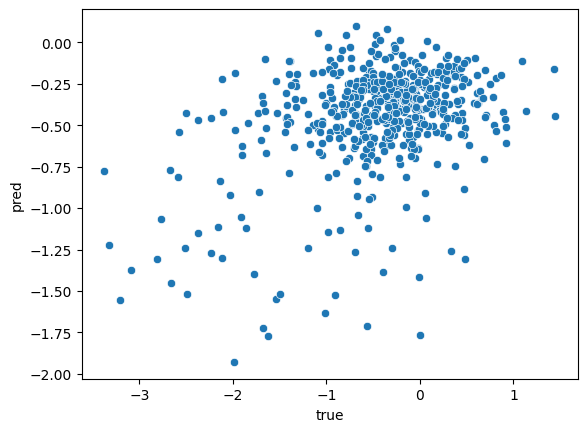

In [58]:
# plot the true vs pred final predictions
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=final_predictions, x='true', y='pred')

In [59]:
#. whats the pearson correlation between true and pred
np.corrcoef(final_predictions["true"], final_predictions["pred"])[0, 1]

np.float64(0.3930343494516315)

In [60]:
# concat all shap values
shap_values = pd.concat(all_shap_values, axis=0)
# concat all X_test
X_test = pd.concat(all_X_test, axis=0)

In [61]:
# fill NaN with 0
X_test = X_test.fillna(0)
shap_values = shap_values.fillna(0)

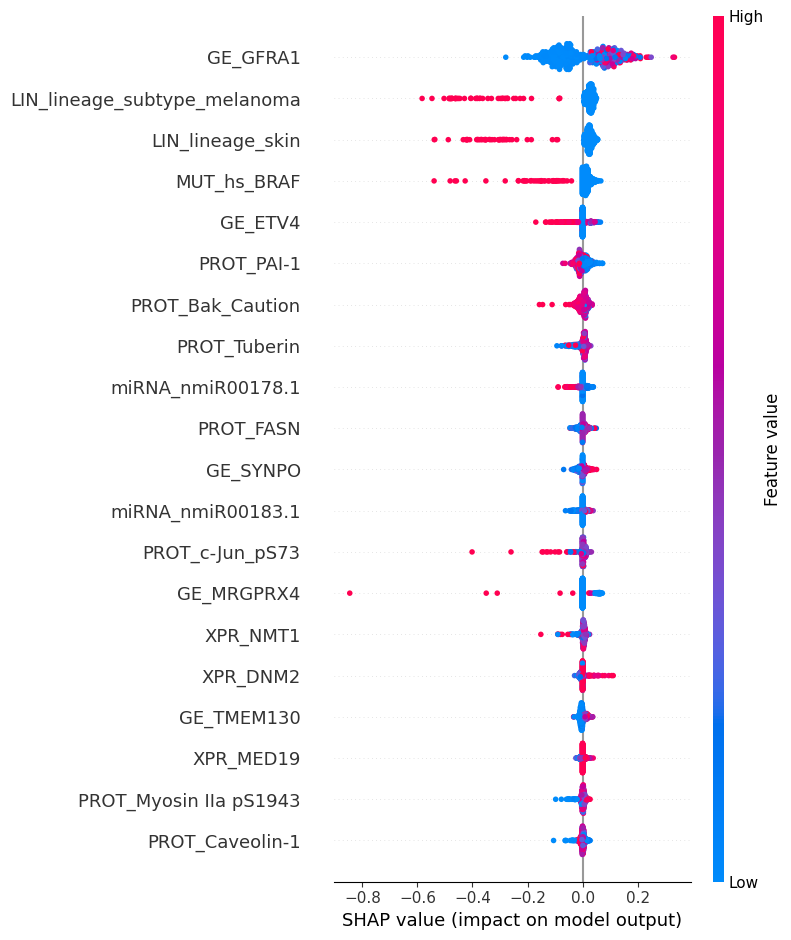

In [62]:
shap.summary_plot(shap_values.values, X_test.values, feature_names=X_test.columns)